In [ ]:
# CPU

### [다중 분류] 도형 인식, CPU

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import random
import datetime

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/shape' # Colab

os.chdir(path) # 기본 경로 설정    
    
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [20]:
height=24
width=24

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        './train',                   # 파일이 있는 폴더 
        target_size=(height, width), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 24 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [24]:
# 네트워크 제작
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

cp = ModelCheckpoint(filepath='./Actor.h5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

start = time.time()

hist = model.fit(
    train_generator,
    epochs=50,
    validation_data = vali_generator,
    callbacks=[cp, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0         
                                                                 
 dense_12 (Dense)            (None, 10)                46090     
                                                                 
 dense_13 (Dense)            (None, 3)                 33        
                                                      

21/24 [=========================>....] - ETA: 0s - loss: 0.2477 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 1.00000
24/24 [==============================] - 0s 14ms/step - loss: 0.2479 - accuracy: 1.0000 - val_loss: 0.3312 - val_accuracy: 0.9333
Epoch 26/50
21/24 [=========================>....] - ETA: 0s - loss: 0.2258 - accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 1.00000
24/24 [==============================] - 0s 14ms/step - loss: 0.2379 - accuracy: 1.0000 - val_loss: 0.3104 - val_accuracy: 0.9333
Epoch 27/50
21/24 [=========================>....] - ETA: 0s - loss: 0.2219 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 1.00000
24/24 [==============================] - 0s 13ms/step - loss: 0.2160 - accuracy: 1.0000 - val_loss: 0.2976 - val_accuracy: 0.9333
Epoch 28/50
21/24 [=========================>....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 1.00000
24/24 [===========================

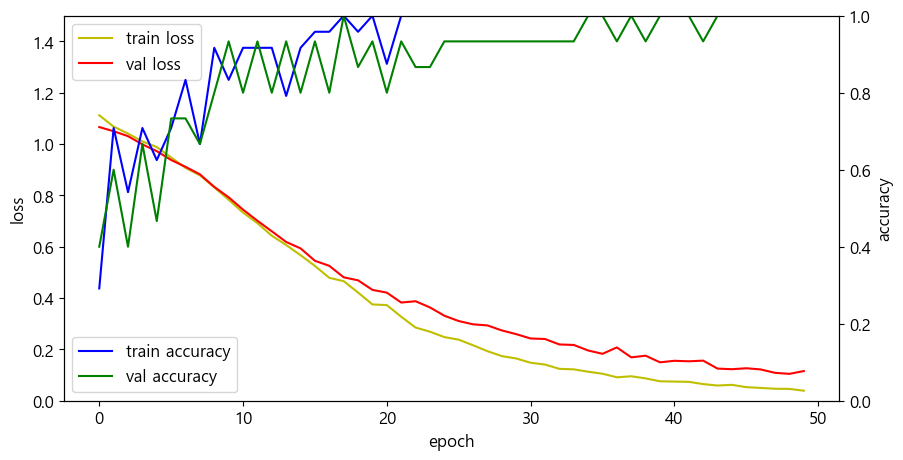

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [26]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 100.00%


In [28]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# numpy package 전체를 설정, 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 15개, 3개의 분류임으로 출력은 15행 3열
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
<class 'numpy.ndarray'>
(15, 3)
[[0.236 0.763 0.001]
 [0.875 0.123 0.002]
 [0.953 0.045 0.002]
 [0.010 0.000 0.990]
 [0.071 0.043 0.886]
 [0.000 0.000 1.000]
 [0.034 0.965 0.000]
 [0.969 0.030 0.002]
 [0.200 0.799 0.001]
 [0.998 0.001 0.001]
 [0.001 0.000 0.999]
 [0.079 0.921 0.000]
 [0.431 0.564 0.005]
 [0.902 0.095 0.002]
 [0.088 0.006 0.906]]


In [29]:
def display(data):  # {'circle': 0, 'rectangle': 1, 'triangle': 2}
    sw = np.argmax(data) # max index
    print('sw:', sw)
    
    if sw == 0:
        sw = '원'
    elif sw == 1:
        sw = '사각형'
    elif sw == 2:
        sw = '삼각형'
        
    return sw     

In [30]:
for row in output:
    print(display(row))
    print('-------------')

sw: 1
사각형
-------------
sw: 0
원
-------------
sw: 0
원
-------------
sw: 2
삼각형
-------------
sw: 2
삼각형
-------------
sw: 2
삼각형
-------------
sw: 1
사각형
-------------
sw: 0
원
-------------
sw: 1
사각형
-------------
sw: 0
원
-------------
sw: 2
삼각형
-------------
sw: 1
사각형
-------------
sw: 1
사각형
-------------
sw: 0
원
-------------
sw: 2
삼각형
-------------


### 테스트 데이터가 적음으로 수업과 결과가 다를 수 있음

In [31]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test1',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')

Found 1 images belonging to 1 classes.


In [32]:
yp = model.predict_generator(test_generator)
print(yp.shape)
print(yp)
print('타겟: 원 /', display(yp))    # 2차원 텐서 전달
print('타겟: 원 /', display(yp[0])) # 1차원 텐서 전달

(1, 3)
[[0.608 0.374 0.017]]
sw: 0
타겟: 원 / 원
sw: 0
타겟: 원 / 원


In [33]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test2',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 사각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.219 0.775 0.005]]
sw: 1
타겟: 사각형 / 사각형


In [34]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test3',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.056 0.017 0.927]]
sw: 2
타겟: 삼각형 / 삼각형


In [35]:
# 64 X 64
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test4',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 원 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.621 0.328 0.050]]
sw: 0
타겟: 원 / 원


In [36]:
# 128 X 128
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test5',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 사각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.311 0.543 0.145]]
sw: 1
타겟: 사각형 / 사각형


In [38]:
# {'circle': 0, 'rectangle': 1, 'triangle': 2}
# 256 X 256, 학습한 이미지와 크기가 다른 이미지 예측시 정확도 떨어짐.
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test6',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.279 0.451 0.271]]
sw: 1
타겟: 삼각형 / 사각형


In [40]:
# {'circle': 0, 'rectangle': 1, 'triangle': 2}
# 256 X 256, 학습한 이미지와 크기가 다른 이미지 예측시 정확도 떨어짐.
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test7',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.461 0.211 0.328]]
sw: 0
타겟: 삼각형 / 원
